## ML course midterm project: Credit Card Fraud Detection

[Dataset link](https://www.kaggle.com/mlg-ulb/creditcardfraud/)


In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, precision_score,recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.exceptions import FitFailedWarning,ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline 
from imblearn.metrics import classification_report_imbalanced
import warnings
warnings.filterwarnings('ignore',category=FitFailedWarning)
warnings.filterwarnings('ignore',category=ConvergenceWarning)

In [2]:
np.random.seed(42)
pd.set_option('max.columns',200)

TEST_SIZE = 0.2

df = pd.read_csv('datasets/creditcard.csv')

## EDA 
Короткий аналіз датасету: розмір, ознаки, їх візуалізація, пропущені дані і т.д.

In [3]:
print(f"Dataset shape: {df.shape}")
df.head(3).append(df.tail(3))

Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


Feature description:
* `Time` - seconds elapsed after first transaction
* `V1` - `V28` - principal components obtained via PCA
* `Amount` - transaction amount
* `Class` - was the transaction fraudulent

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Feature processing:
* We'll normalize `Time` and `Amount` (all other values were previously scaled via PCA)
* We'll add `Hour` to see a relationship between daytime and number of transactions

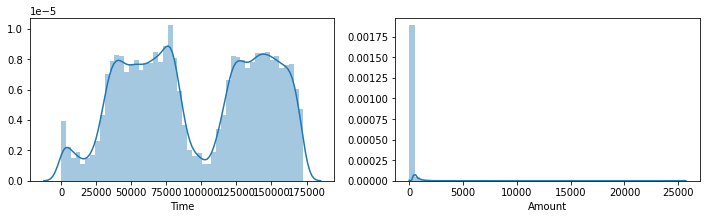

In [5]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,3))
sns.distplot(df.Time,ax=axes[0])
sns.distplot(df.Amount,ax=axes[1]);

In [6]:
df['Hour'] = df.Time.apply(lambda x: np.ceil(x/3600)%24)

robust_scaler = RobustScaler()

for col in ['Time','Amount','Hour']:
    df['Scaled_'+col] = robust_scaler.fit_transform(df[col].values.reshape(-1,1))

df.drop(['Time','Amount','Hour'],axis=1,inplace=True)

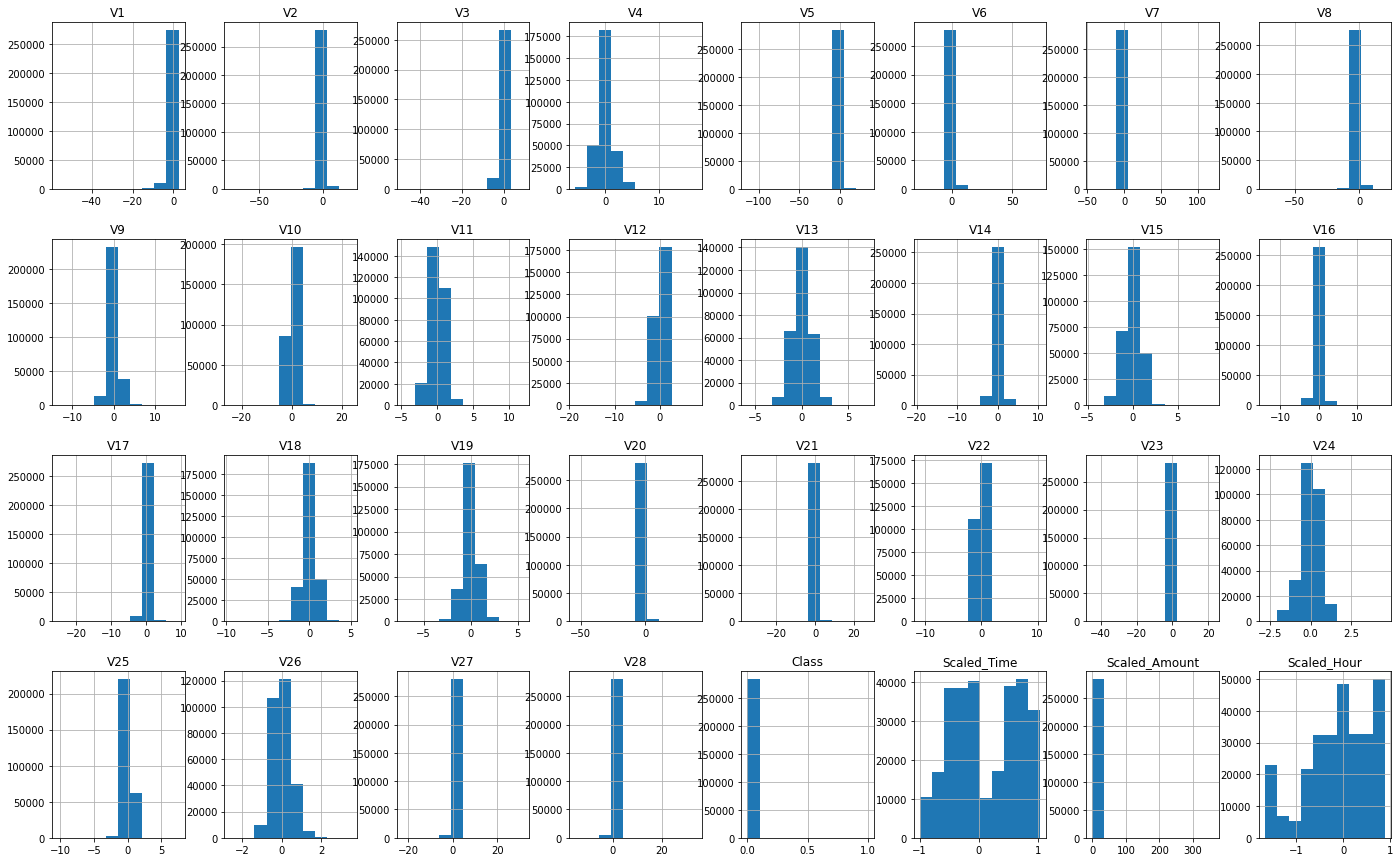

In [7]:
df.hist(layout=(4,8),figsize=(24,15));

In [8]:
df.isna().sum() #no missing values, yeey

V1               0
V2               0
V3               0
V4               0
V5               0
V6               0
V7               0
V8               0
V9               0
V10              0
V11              0
V12              0
V13              0
V14              0
V15              0
V16              0
V17              0
V18              0
V19              0
V20              0
V21              0
V22              0
V23              0
V24              0
V25              0
V26              0
V27              0
V28              0
Class            0
Scaled_Time      0
Scaled_Amount    0
Scaled_Hour      0
dtype: int64

classes distribution:
0    284315
1       492
Name: Class, dtype: int64
percentage of fraud transactions: 0.1727%


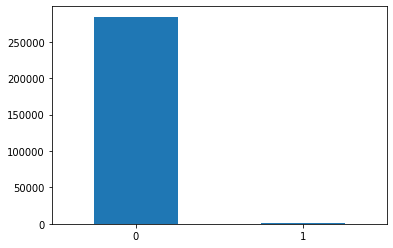

In [9]:
df.Class.value_counts().plot(kind='bar')
print(f"classes distribution:\n{df.Class.value_counts()}\npercentage of fraud transactions: {100 * df.Class.value_counts()[1]/df.shape[0]:.4f}%")
plt.xticks(rotation=0);

Data is extremely imbalanced

1. Робота з лінійними моделями. Продемонструйте, які результати можна отримати
шляхом попередньої обробки даних та утворення нових ознак.

#### (SPOILER) Wrong way:

In [10]:
X = df.copy()
y = X.pop('Class')


Share of fraud transactions in train set: 0.0017
Share of fraud transactions in test set: 0.0017

Classifier: LogisticRegression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



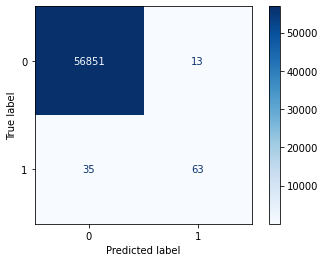

Classifier: KNeighborsClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.81      0.85        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



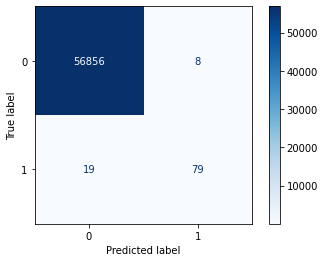

Classifier: SVC

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.49      0.62        98

    accuracy                           1.00     56962
   macro avg       0.92      0.74      0.81     56962
weighted avg       1.00      1.00      1.00     56962



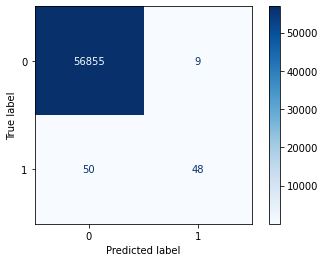

Classifier: DecisionTreeClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.74      0.74        98

    accuracy                           1.00     56962
   macro avg       0.87      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962



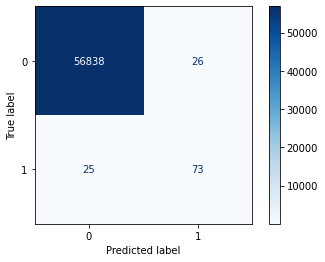

In [11]:
full_X_train,full_X_test,full_y_train,full_y_test = train_test_split(X,y,stratify=y,test_size=TEST_SIZE,random_state=42)
print(f"\nShare of fraud transactions in train set: {full_y_train.value_counts()[1]/full_y_train.value_counts()[0]:.4f}\nShare of fraud transactions in test set: {full_y_test.value_counts()[1]/full_y_test.value_counts()[0]:.4f}\n")

for clf in [LogisticRegression(),KNeighborsClassifier(n_neighbors=3,leaf_size=10,n_jobs=-1), SVC(max_iter=100),DecisionTreeClassifier()]:
    clf.fit(full_X_train,full_y_train)
    y_pred = clf.predict(full_X_test)

    print(f"Classifier: {clf.__class__.__name__}\n")
    print(classification_report(full_y_test, clf.predict(full_X_test)))
    plot_confusion_matrix(clf, full_X_test,full_y_test,cmap='Blues')
    plt.show()

Interestingly, most stock classifiers perform relatively well. Perhaps that's due to normalization (though I'm not sure). Anyway, we know that this approach is incorrect

### Better way - Random Under-sampling - Creating an equal subsample.
Why is it important:
* imbalance of classes makes classifiers 'assume there is no fraud'
* it is harder for a classifier to recognize the patterns in fraud -> overfitting
* it is harder for us to see correlations between variables -> misinformation
* value_counts

Steps:
* create subsample - we have 492 examples of fraud; let's concate them with 492 random examples of non-fraud

In [12]:
sample_df = df.copy()
sample_df = sample_df.sample(frac=1) # shuffle the data

fraud = sample_df.loc[df.Class==1]
non_fraud = sample_df.loc[df.Class==0][:492]

new_df = pd.concat([fraud, non_fraud])
new_df = new_df.sample(frac=1)#reshuffle it again

del sample_df,fraud, non_fraud
new_df.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

Exploring correlations is now a completely different story!

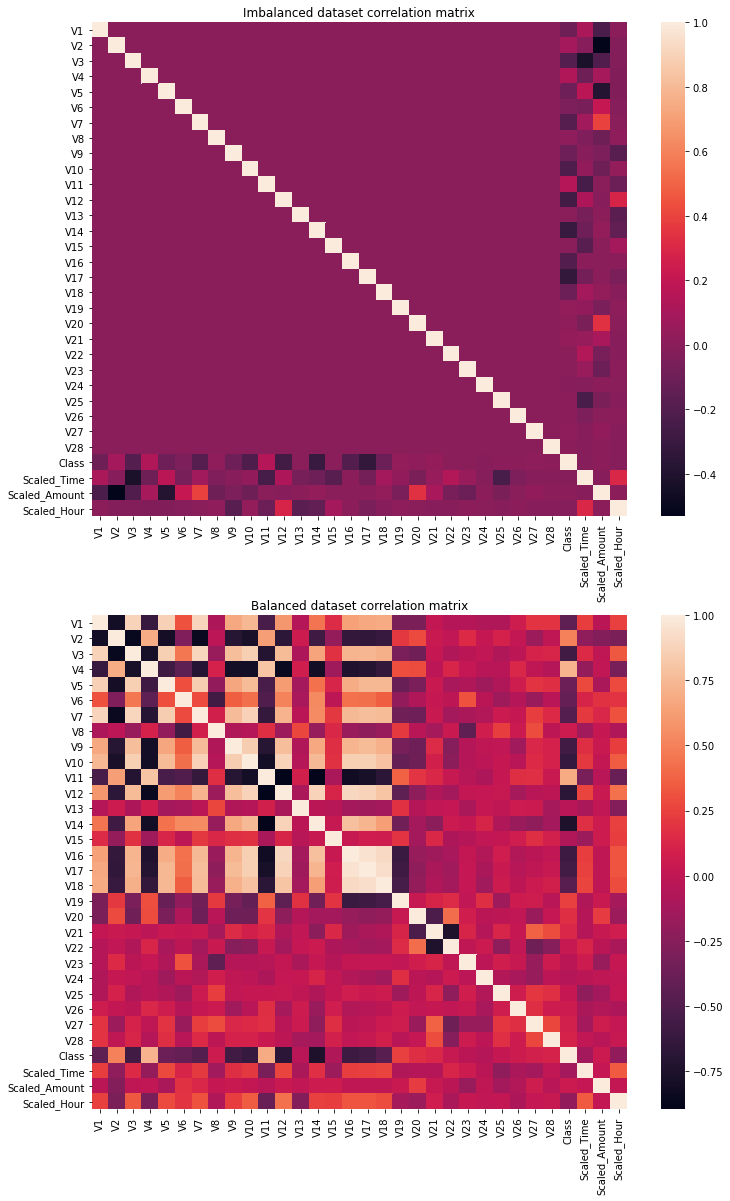

In [13]:
fig,axes = plt.subplots(nrows=2,ncols=1, figsize =(12,20))
sns.heatmap(df.corr(),ax=axes[0])
axes[0].set_title("Imbalanced dataset correlation matrix")
new_corr = new_df.corr()
sns.heatmap(new_corr,ax=axes[1]);
axes[1].set_title("Balanced dataset correlation matrix");

Let's do some modeling:

Classifier: LogisticRegression
Classification report @ small test set

              precision    recall  f1-score   support

           0       0.93      0.99      0.96        99
           1       0.99      0.93      0.96        98

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197
 
Classification report @ full test set
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962
 




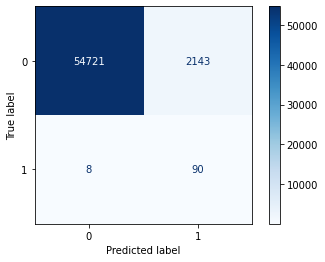

Classifier: KNeighborsClassifier
Classification report @ small test set

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        99
           1       0.99      0.90      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197
 
Classification report @ full test set
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.95      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.96      0.53     56962
weighted avg       1.00      0.96      0.98     56962
 




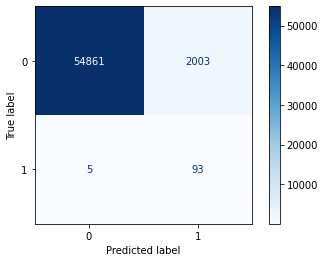

Classifier: SVC
Classification report @ small test set

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        99
           1       1.00      0.89      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197
 
Classification report @ full test set
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.89      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.58     56962
weighted avg       1.00      0.99      0.99     56962
 




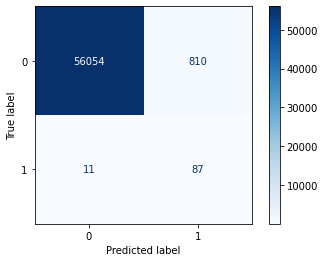

Classifier: DecisionTreeClassifier
Classification report @ small test set

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        99
           1       0.96      0.93      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197
 
Classification report @ full test set
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     56864
           1       0.01      1.00      0.03        98

    accuracy                           0.89     56962
   macro avg       0.51      0.94      0.48     56962
weighted avg       1.00      0.89      0.94     56962
 




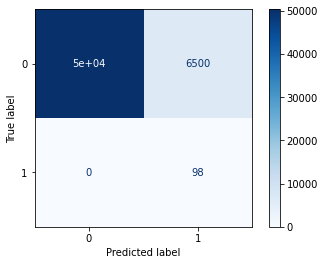

In [14]:
X_train,X_test,y_train,y_test = train_test_split(new_df.loc[:,new_df.columns!='Class'],new_df['Class'],test_size=TEST_SIZE,stratify=new_df['Class'],random_state=42)

for clf in [LogisticRegression(),KNeighborsClassifier(n_neighbors=3,leaf_size=10,n_jobs=-1), SVC(),DecisionTreeClassifier()]:
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(f"Classifier: {clf.__class__.__name__}\nClassification report @ small test set\n")
    print(classification_report(y_test, y_pred),'\nClassification report @ full test set')
    print(classification_report(full_y_test,clf.predict(full_X_test)),'\n\n')
    plot_confusion_matrix(clf, full_X_test,full_y_test,cmap='Blues')
    plt.show()

As we may see, models perform much worse in regard of class '1'. Perhaps, that's due to the tremendous loss of information in class '0'. 

2. Підбір гіперпараметрів.

Wall time: 2.41 s
Classifier:LogisticRegression
grid_search best params: {'C': 0.001, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2'}
clf params:
{'C': 0.001, 'class_weight': {0: 1, 1: 1}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Classification report @ small test set
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        99
           1       1.00      0.86      0.92        98

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197
 
Classification report @ full test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.85      0.60        98


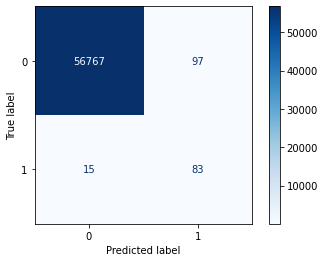

Wall time: 297 ms
Classifier:KNeighborsClassifier
grid_search best params: {'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}
clf params:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
Classification report @ small test set
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        99
           1       0.98      0.91      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197
 
Classification report @ full test set
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.05      1.00      0.09        98

    accuracy                           0.96     56962
   macro avg       0.52      0.98      0.54     56962
weighted avg       1.00

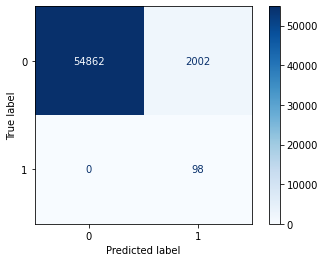

Wall time: 218 ms
Classifier:SVC
grid_search best params: {'C': 0.9, 'kernel': 'rbf'}
clf params:
{'C': 0.9, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 1000, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classification report @ small test set
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        99
           1       1.00      0.89      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197
 
Classification report @ full test set
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.89      0.17        98

    accuracy                           0.99     569

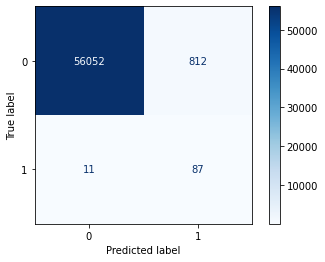

Wall time: 289 ms
Classifier:DecisionTreeClassifier
grid_search best params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 7}
clf params:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}
Classification report @ small test set
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        99
           1       0.96      0.92      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197
 
Classification report @ full test set
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
       

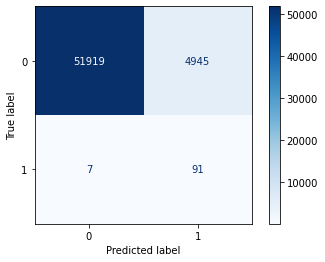

In [15]:
grid_search_params = {
    LogisticRegression():{'penalty':['l2'], 'C':[.001,.01,.1,1.,10.,100,1000],'class_weight':[{0:1,1:1},{0:1,1:5},{0:1,1:10}]},
    KNeighborsClassifier():{'n_neighbors':[2,3,4], 'algorithm':['auto','kd_tree'],'weights':['uniform','distance']},
    SVC(max_iter=1000):{'C':[.5,.75,.9,1.], 'kernel':['rbf','linear','sigmoid']},
    DecisionTreeClassifier():{'criterion':['gini','entropy'],'max_depth':[2,3,4],'min_samples_leaf':[4,5,6,7]}
}
best_clf = []

for model, gs_params in grid_search_params.items():
    grid_search = GridSearchCV(model,gs_params,n_jobs=-1,cv=3,verbose=0,scoring='roc_auc')
    %time grid_search.fit(X_train,y_train)
    clf = grid_search.best_estimator_
    
    print(f"Classifier:{clf.__class__.__name__}\ngrid_search best params: {grid_search.best_params_}\nclf params:\n{clf.get_params()}\nClassification report @ small test set")
    print(classification_report(y_test, clf.predict(X_test)),'\nClassification report @ full test set')
    print(classification_report(full_y_test,clf.predict(full_X_test)),'\n\n')
    plot_confusion_matrix(clf,full_X_test,full_y_test,cmap='Blues')
    plt.show();
    best_clf.append((clf.__class__.__name__,clf))

Tuning parameters over GridSearch actually improves our results! We should consider this while doing training

3. Ансамбль моделей (тут мається на увазі ансамбль, утворений Вами самостійно, на
противагу, наприклад, Random Forest).

Ansamble of poorly performing models performs averagely poor

Classification report @ small test set
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        99
           1       1.00      0.91      0.95        98

    accuracy                           0.95       197
   macro avg       0.96      0.95      0.95       197
weighted avg       0.96      0.95      0.95       197

Classification report @ full test set
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.93      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.96      0.98     56962
 




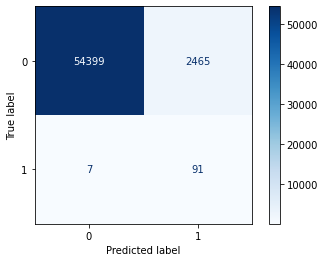

In [16]:
estimators = [
    ('log_reg',clf), 
    ('knn_clf',KNeighborsClassifier()),
    ('svc', SVC()),
    ('tree_clf',DecisionTreeClassifier())]
stacking_clf = StackingClassifier(estimators=estimators,n_jobs=-1,verbose=3)
stacking_clf.fit(X_train, y_train)

print('Classification report @ small test set\n',classification_report(y_test, stacking_clf.predict(X_test)))
print('Classification report @ full test set\n',classification_report(full_y_test,stacking_clf.predict(full_X_test)),'\n\n')
plot_confusion_matrix(stacking_clf,full_X_test,full_y_test,cmap='Blues');

Classification report @ small test set
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        99
           1       1.00      0.91      0.95        98

    accuracy                           0.95       197
   macro avg       0.96      0.95      0.95       197
weighted avg       0.96      0.95      0.95       197

Classification report @ full test set
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      1.00      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.98      0.54     56962
weighted avg       1.00      0.97      0.98     56962
 




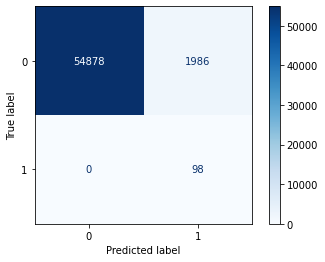

In [17]:
rf_clf = RandomForestClassifier(n_jobs=-1,verbose=0)
rf_clf.fit(X_train, y_train)

print('Classification report @ small test set\n',classification_report(y_test, rf_clf.predict(X_test)))
print('Classification report @ full test set\n',classification_report(full_y_test,rf_clf.predict(full_X_test)),'\n\n')

plot_confusion_matrix(rf_clf,full_X_test,full_y_test,cmap='Blues');

4. "Дикий експеримент". Спробуйте щось нове, навіть якщо це не принесе прогресу у
розв'язку задачі. Натренуйте SVM з власним ядром, сконструюйте нові ознаки,
перебалансуйте вибірку, синтезуйте дані шляхом додавання шуму або лінійних
опуклих комбінацій тощо - зробіть те, що здається Вам логічним та цікавим.

### SMOTE - Synthetic minority over-sampling technique
* We create artificial points of a minority class close to real ones to make a dataset more balanced 
* We don't lose information



* Important moment - points should be created during cross-validation - otherwise, we'll evaluate algorithm on part of the points we generated + the results become uncomparable - test set should remain intact


#### Naive Way: upsampling to 1:1

We will use LogisticRegression

Classification report @ upsampled test set
               precision    recall  f1-score   support

           0       0.93      0.98      0.95    227451
           1       0.98      0.92      0.95    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.95    454902
weighted avg       0.95      0.95      0.95    454902

Classification report @ full test set
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962
 




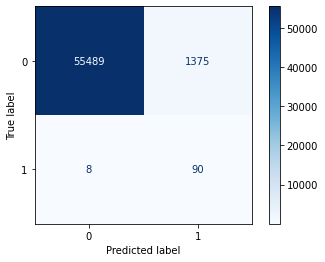

In [18]:
print (f"We will use {best_clf[0][0]}\n")
sm = SMOTE(sampling_strategy='minority',n_jobs=-1)
X_t,y_t = sm.fit_resample(full_X_train,full_y_train)
lr_clf = best_clf[0][1]
lr_clf.fit(X_t,y_t).score(X_t,y_t)
print('Classification report @ upsampled test set\n',classification_report(y_t, lr_clf.predict(X_t)))
print('Classification report @ full test set\n',classification_report(full_y_test,lr_clf.predict(full_X_test)),'\n\n')
plot_confusion_matrix(lr_clf, full_X_test,full_y_test,cmap='Blues')
plt.show()

As we may see, performance is quite awful. Most likely, 500 points isn't enough to generate 200k+ adequate points. However, we may try upsampling to a more reasonable number of points
#### Second approach: Upsample from 500 to 5000

Ratio:1000
Classification report @ full test set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.63      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962
 




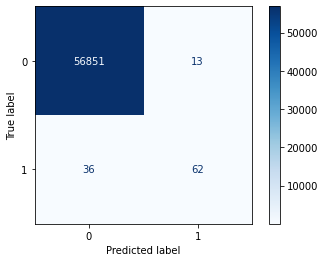

Ratio:2500
Classification report @ full test set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.80      0.76        98

    accuracy                           1.00     56962
   macro avg       0.86      0.90      0.88     56962
weighted avg       1.00      1.00      1.00     56962
 




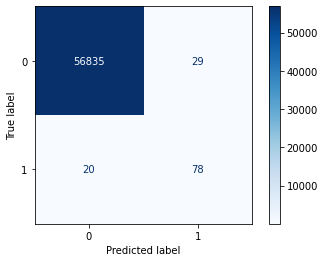

Ratio:5000
Classification report @ full test set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.84      0.78        98

    accuracy                           1.00     56962
   macro avg       0.87      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962
 




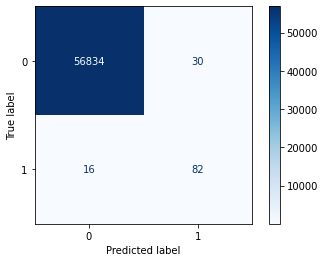

Ratio:7500
Classification report @ full test set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.85      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962
 




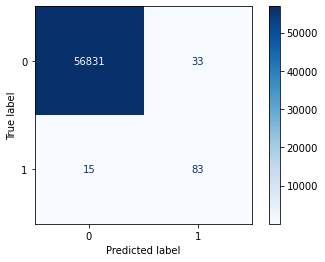

Ratio:10000
Classification report @ full test set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.85      0.77        98

    accuracy                           1.00     56962
   macro avg       0.85      0.92      0.88     56962
weighted avg       1.00      1.00      1.00     56962
 




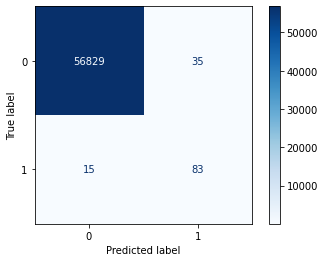

Ratio:15000
Classification report @ full test set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.62      0.87      0.72        98

    accuracy                           1.00     56962
   macro avg       0.81      0.93      0.86     56962
weighted avg       1.00      1.00      1.00     56962
 




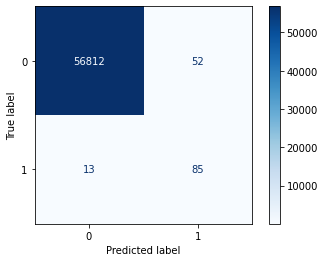

In [19]:
warnings.filterwarnings('ignore')
for ratio in [1000,2500,5000,7500,10000,15000]:
    sm = SMOTE(ratio/y.value_counts()[0],n_jobs=-1)
    X_t,y_t = sm.fit_resample(full_X_train,full_y_train)
    lr_clf = best_clf[0][1]
    lr_clf.fit(X_t,y_t).score(X_t,y_t)
    print(f'Ratio:{ratio}')
    print('Classification report @ full test set\n',classification_report(full_y_test,lr_clf.predict(full_X_test)),'\n\n')
    plot_confusion_matrix(lr_clf, full_X_test,full_y_test,cmap='Blues')
    plt.show()

The confusion matrices above show that the influence of upsampling to performance has its own limits: f1 for minority class reaches its peak of 0.79 at a number of 5000 minority examples. After that it starts to drop. I believe it is caused by the `quality` of higher number of generated points. Let's do a small grid search and check how other classifiers perform at the same 5000 examples

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   16.8s finished


Wall time: 19 s
Classifier:LogisticRegression
grid_search best params: {'C': 0.01, 'penalty': 'l2'}
clf params:
{'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.85      0.77        98

    accuracy                           1.00     56962
   macro avg       0.85      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962
 




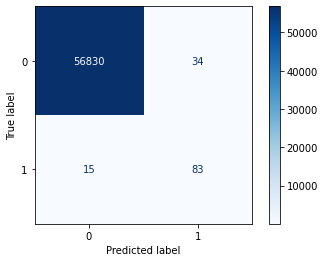

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 40.1min finished


Wall time: 40min 9s
Classifier:KNeighborsClassifier
grid_search best params: {'leaf_size': 5, 'n_neighbors': 3, 'weights': 'distance'}
clf params:
{'algorithm': 'auto', 'leaf_size': 5, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.66      0.85      0.74        98

    accuracy                           1.00     56962
   macro avg       0.83      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962
 




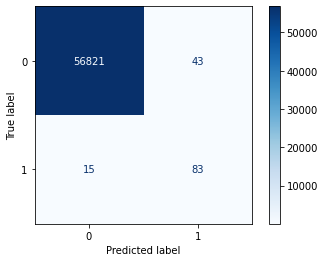

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 30.0min finished


Wall time: 30min 37s
Classifier:SVC
grid_search best params: {'C': 1.0, 'kernel': 'rbf'}
clf params:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 2000, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962
 




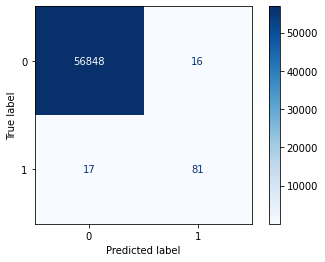

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   56.1s finished


Wall time: 1min 2s
Classifier:DecisionTreeClassifier
grid_search best params: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 7}
clf params:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.85      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962
 




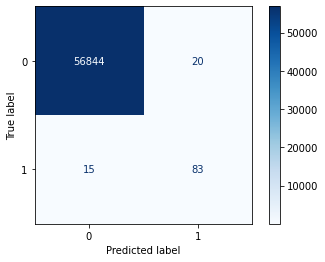

In [20]:
sm = SMOTE(5000/y.value_counts()[0],n_jobs=-1)
X_t,y_t = sm.fit_resample(full_X_train,full_y_train)

grid_search_params = {
    LogisticRegression():{'penalty':['l2'], 'C':[.001,.01,.1,1.,10.,100,1000]},
    KNeighborsClassifier():{'n_neighbors':[3,5], 'weights':['uniform','distance'],'leaf_size':[5,10,15]},
    SVC(max_iter=2000):{'C':[.5,.75,.9,1.], 'kernel':['rbf','linear','sigmoid']},
    DecisionTreeClassifier():{'criterion':['gini','entropy'],'max_depth':[2,3,4],'min_samples_leaf':[4,5,6,7]}
}
best_clf = []

for model, gs_params in grid_search_params.items():
    grid_search = GridSearchCV(model,gs_params,n_jobs=-1,cv=3,verbose=2)
    %time grid_search.fit(X_t,y_t)
    clf = grid_search.best_estimator_
    
    print(f"Classifier:{clf.__class__.__name__}\ngrid_search best params: {grid_search.best_params_}\nclf params:\n{clf.get_params()}\n")
    print(classification_report(full_y_test,clf.predict(full_X_test)),'\n\n')
    plot_confusion_matrix(clf,full_X_test,full_y_test,cmap='Blues')
    plt.show();
    best_clf.append((clf.__class__.__name__,clf))

5. Висновок. Короткі підсумки Вашої роботи.

* using imbalanced data harms your model
* undersampling is not useful because it may harm your model
* smote is better, but we should be careful about its adequacy - generating too many points is impossible and will rather generate noise than increase performance